In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# read in our data
store_data = pd.read_csv("data/google-play-store-apps/googleplaystore.csv")
reviews_data = pd.read_csv("data/google-play-store-apps/googleplaystore_user_reviews.csv")

In [3]:
# some stuff that could be used
# pd.isnull(store_data).sum() > 0
# store_data.isna().any(axis=0)
# store_data.loc[store_data['Price'].isnull()]
# print(store_data.iloc[5]['Price'])
# store_data[pd.isnull(store_data).any(axis=1)]

## Checking out the missing values

First we inspect and check which attributes in the data have missing values.

In [4]:
pd.isnull(store_data).sum() > 0

App               False
Category          False
Rating             True
Reviews           False
Size              False
Installs          False
Type               True
Price             False
Content Rating     True
Genres            False
Last Updated      False
Current Ver        True
Android Ver        True
dtype: bool

The `Rating`, `Type`, `Content Rating`, `Current Ver`, `Android Ver` attributes turned out to have NaN values.

---

#### Type:

Let's start with `Type`; which is the attribute that indicates whether the app is `Paid` or `Free`.

In [5]:
store_data.loc[store_data['Type'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
9148,Command & Conquer: Rivals,FAMILY,NaN,0,Varies with device,0,NaN,0,Everyone 10+,Strategy,"June 28, 2018",Varies with device,Varies with device


So the app in row `9148` named `Command & Conquer: Rivals` appears to be the only one with NaN value in `Type`.

Since its `Price` attribute holds a price of $0, we could safely assume that it is a free app and fix the value of the `Type` to `Free`. Also, this assumption is confirmed by checking that the app is indeed free on the Android play store.

In [6]:
store_data.iloc[9148, store_data.columns.get_loc('Type')] = 'Free'
store_data.loc[store_data['Type'].isnull()]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


---

#### Rating:

The `Rating` attribute represent the rating given by the users for the app on a scale from 1 to 5.

In [7]:
store_data['Rating'].isnull().sum()

1474

There appears to be 1474 apps with missing rating values. There are a few approaches of adjusting these missing values. We decided to change each one of with a mean of ratings of other apps with same range of installs. For e.g: app 2 has a missing rating value and `100,000+` installs, if the mean rating of all the others apps with `100,000+` installs is `3.5`, then app 2's rating will be adjusted to `3.5`

We first start by grouping the data by the number of installs, and finding the mean rating for each range of number of installs. This forms "installs_rating_info" dataframe that will be further used for rating imputations. 0 installs were given 0 rating.

In [8]:
grouped_installs = store_data.groupby(["Installs"])
installs_rating_info = grouped_installs.agg(np.mean)
installs_rating_info = installs_rating_info.fillna(0)
installs_rating_info

,Rating
Installs,
0,0.000000
0+,0.000000
1+,5.000000
"1,000+",4.066760
"1,000,000+",4.220862
"1,000,000,000+",4.258621
10+,4.624638
"10,000+",4.039703
"10,000,000+",4.313419


A merge is formed between the "installs_rating_info" and another dataframe "nanRatings" that contains the same rows of "store_data" that contain the Rating "NaN" (1474 rows). This merge results in a new updated dataframe, called "updated_Rating" that has the same data as "nanRatings" but the "Rating" values have been replaced with the mean values per their number of installs values.

In [9]:
nanRatings = store_data[store_data['Rating'].isnull()]
nanRatings.rename(columns={'Rating':'Old_Rating'}, inplace=True)
updated_Rating = pd.merge(nanRatings, installs_rating_info, left_on='Installs', right_on='Installs').drop('Old_Rating', axis=1)

c:\users\ahmed\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


To impute the "store_data" rating values, we loop over the "updated_Rating" dataframe, replacing every rating of every row of NaN rating values in store_data with the respective rating of same application from updated_Rating df. This results in 0 NaN ratings in our data.

In [10]:
for index, row in updated_Rating.iterrows():
    indexOfApp = store_data[store_data['App']==row['App']].index
    store_data.at[indexOfApp, 'Rating'] = row['Rating']
    
print(store_data['Rating'].isnull().sum())

0


#### Shifted Row:
Row 10472 had shifted data by 1 to the left and a missing category value. To fix this, we shifted each cell by 1 and checked Google Playstore for its category and genre values, both are Lifestyle.

In [11]:
store_data.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                                 19
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

In [12]:
indexOfShiftedRow = store_data[store_data['App'] == store_data.iloc[10472]['App']].index[0]

In [13]:
store_data.at[indexOfShiftedRow,"Android Ver"] = store_data.at[indexOfShiftedRow,"Current Ver"]
store_data.at[indexOfShiftedRow,"Current Ver"] = store_data.at[indexOfShiftedRow,"Last Updated"]
store_data.at[indexOfShiftedRow,"Last Updated"] = store_data.at[indexOfShiftedRow,"Genres"]
store_data.at[indexOfShiftedRow,"Genres"] = "LifeStyle"
store_data.at[indexOfShiftedRow,"Content Rating"] = store_data.at[indexOfShiftedRow,"Price"]
store_data.at[indexOfShiftedRow,"Price"] = store_data.at[indexOfShiftedRow,"Type"]
store_data.at[indexOfShiftedRow,"Type"] = store_data.at[indexOfShiftedRow,"Installs"]
store_data.at[indexOfShiftedRow,"Installs"] = store_data.at[indexOfShiftedRow,"Size"]
store_data.at[indexOfShiftedRow,"Size"] = store_data.at[indexOfShiftedRow,"Reviews"]
store_data.at[indexOfShiftedRow,"Reviews"] = store_data.at[indexOfShiftedRow,"Rating"]
store_data.at[indexOfShiftedRow,"Rating"] = store_data.at[indexOfShiftedRow,"Category"]
store_data.at[indexOfShiftedRow,"Category"] = "LIFESTYLE"

In [14]:
store_data.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                        LIFESTYLE
Rating                                                1.9
Reviews                                                19
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                          LifeStyle
Last Updated                            February 11, 2018
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

#### Andriod Version:

Two rows have missing 'Andriod Ver' attribute, their andriod version values will be retrieved from the Google Playstore and filled by this values.

In [15]:
store_data['Android Ver'].isnull().sum()

2

In [16]:
store_data[store_data['Android Ver'].isnull() == True ]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4453,[substratum] Vacuum: P,PERSONALIZATION,4.4,230,11M,"1,000+",Paid,$1.49,Everyone,Personalization,"July 20, 2018",4.4,NaN
4490,Pi Dark [substratum],PERSONALIZATION,4.5,189,2.1M,"10,000+",Free,0,Everyone,Personalization,"March 27, 2018",1.1,NaN


In [17]:
store_data.at[4490, "Android Ver"] = 1.1
store_data.at[4453, "Android Ver"] = 6.1

In [18]:
store_data[store_data['Android Ver'].isnull() == True ]

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver


In [19]:
pd.isnull(store_data).sum() > 0

App               False
Category          False
Rating            False
Reviews           False
Size              False
Installs          False
Type              False
Price             False
Content Rating    False
Genres            False
Last Updated      False
Current Ver        True
Android Ver       False
dtype: bool

Now this dataset is cleaned with no missing values in any attribute except 'Current Ver' because its imputation won't be of major consequences to our data handling.

#### Google Playstore UserReviews:

We need to clean this data as well, this would be easier, any null values of reviews will be dropped because it can't be imputed.

In [20]:
pd.isnull(reviews_data).sum() 

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [21]:
reviews_data_new = reviews_data.dropna().head()
reviews_data_new

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [22]:
pd.isnull(reviews_data_new).sum() 

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

Now done with the data cleaning for both datasets, time for our next step!

In [23]:
store_data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

Change Reviews column to be int

In [58]:
store_data.Reviews = store_data.Reviews.astype('int32')

Change Price column to be float

In [25]:
for index, row in store_data.iterrows():
    store_data.at[index, 'Price'] = row['Price'].replace('$', '')
store_data.Price = store_data.Price.astype('float64')
store_data.dtypes

App                object
Category           object
Rating            float64
Reviews             int32
Size               object
Installs           object
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

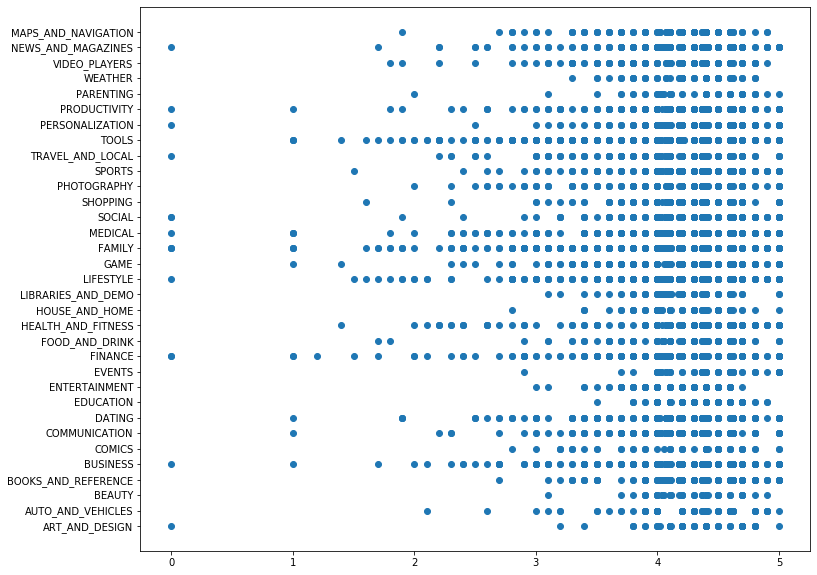

In [27]:
fig = plt.figure(figsize=(12,10))
plt.show(plt.scatter(store_data.Rating, store_data.Category))

Change Installs to be int

In [59]:
store_data['Installs'] = store_data['Installs'].str.replace('+','')
store_data['Installs'] = store_data['Installs'].str.replace(',','')
store_data['Installs'] = store_data['Installs'].astype('int32')

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

Change Size to be float

In [100]:
store_data_copy = store_data.copy()
store_data_copy['Size'] = store_data_copy['Size'].str.replace('k','e+3')
store_data_copy['Size'] = store_data_copy['Size'].str.replace('M','e+6')
store_data_copy['Size'] = store_data_copy['Size'].replace('Varies with device', np.nan)
store_data_copy['Size'] = store_data_copy['Size'].astype('float')

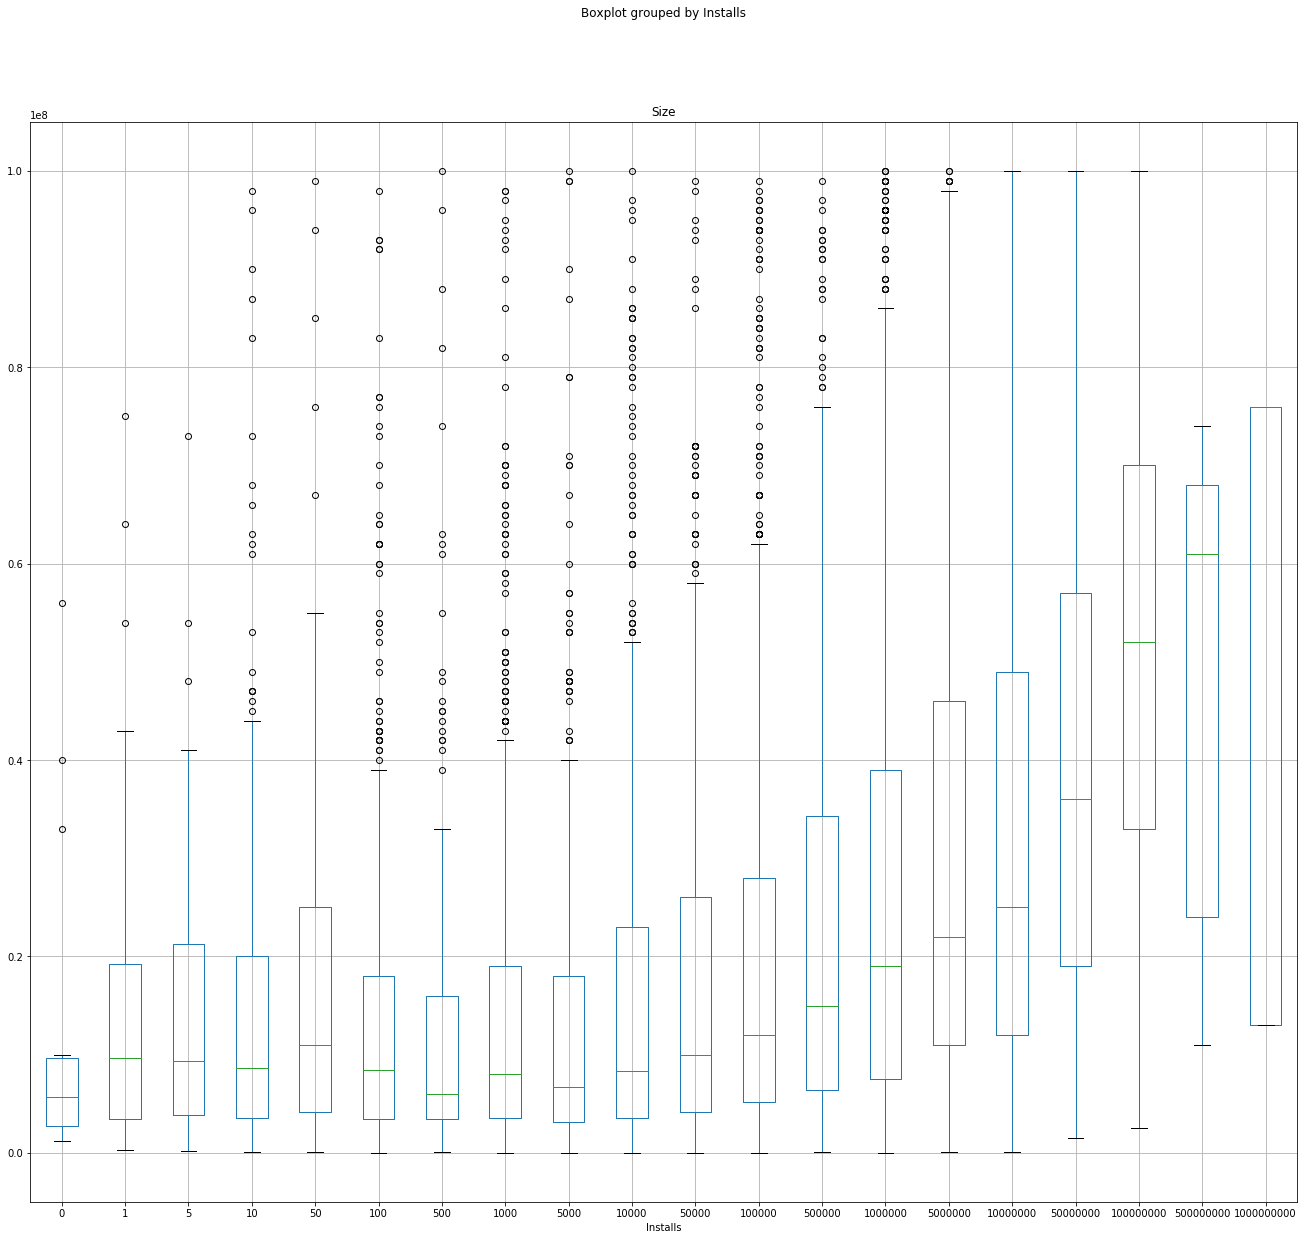

In [109]:
store_data_copy.boxplot(column='Size', by='Installs', figsize=(22,20))

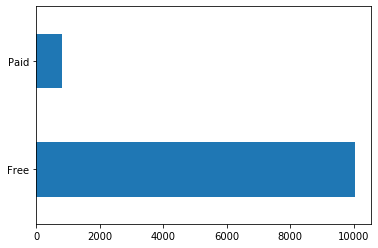

In [73]:
store_data_copy['Type'].value_counts().plot(kind='barh')

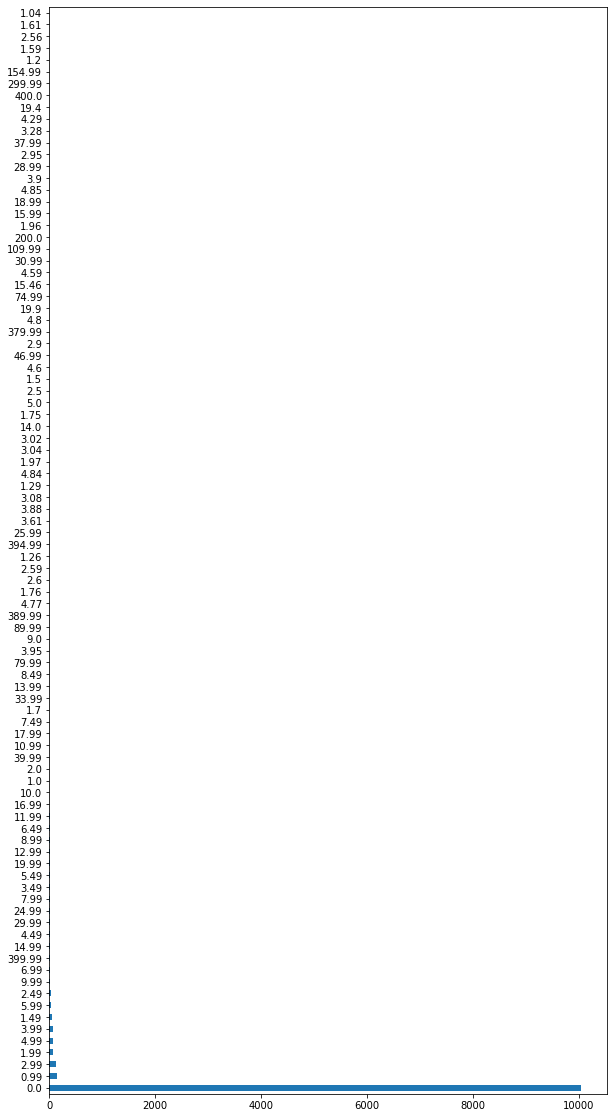

In [87]:
store_data_copy['Price'].value_counts().plot(kind='barh', figsize=(10,20))

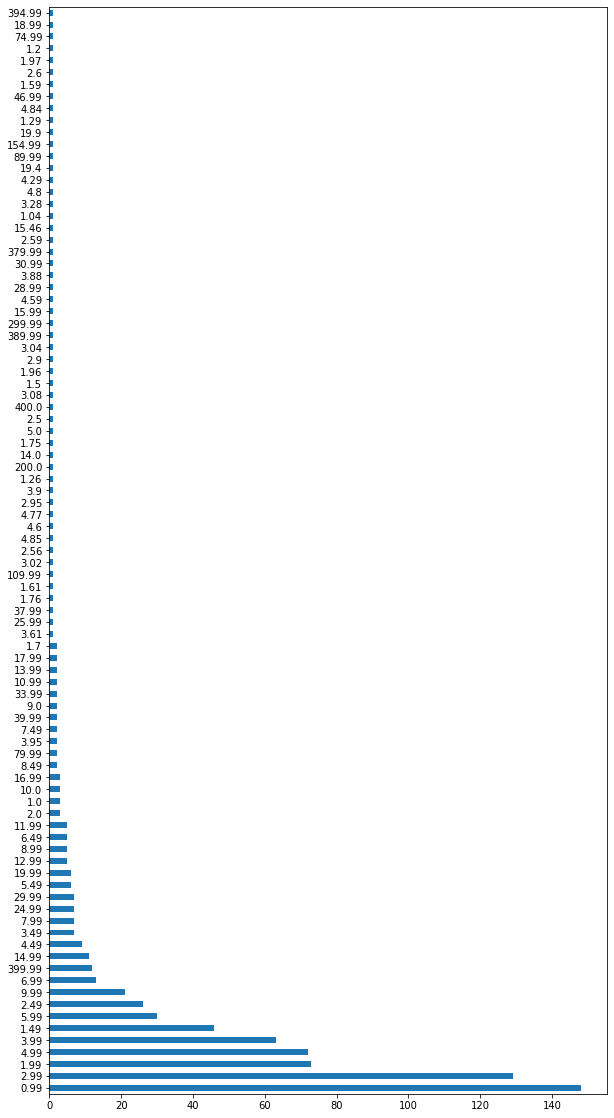

In [108]:
df = store_data[store_data.Price != 0.0]
df['Price'].value_counts().plot(kind='barh', figsize=(10,20))
# plt.figure(figsize=(20,5))
# sns.boxplot(
#     data=store_data_copy,
#     x='Installs',
#     y='Reviews',
#     color='red')

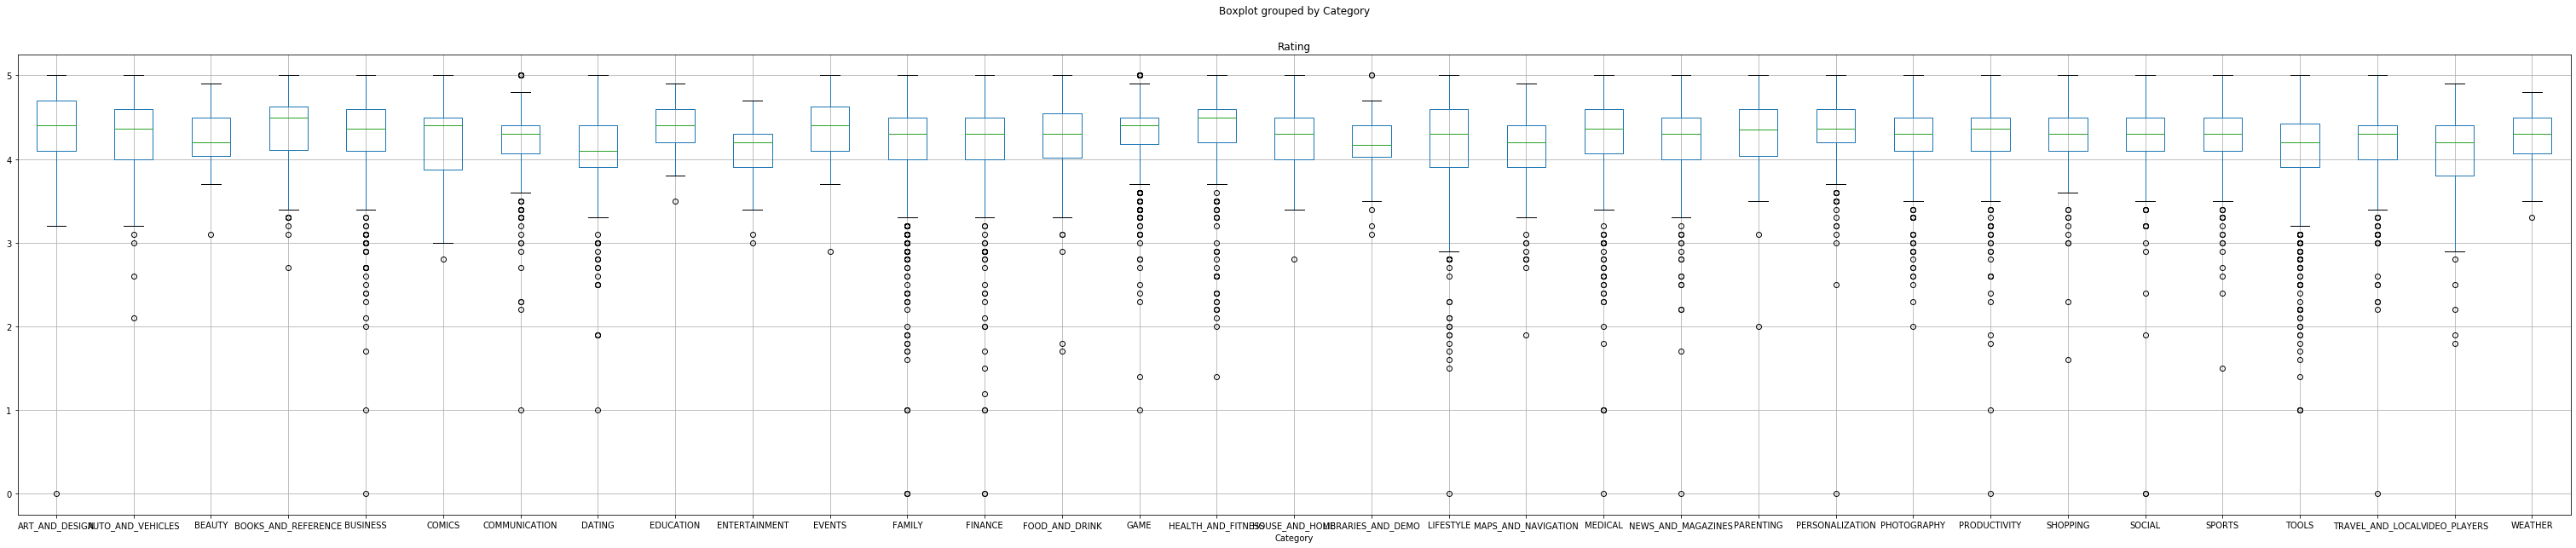

In [123]:
store_data_copy.boxplot(column='Rating', by='Category', figsize=(52,10))

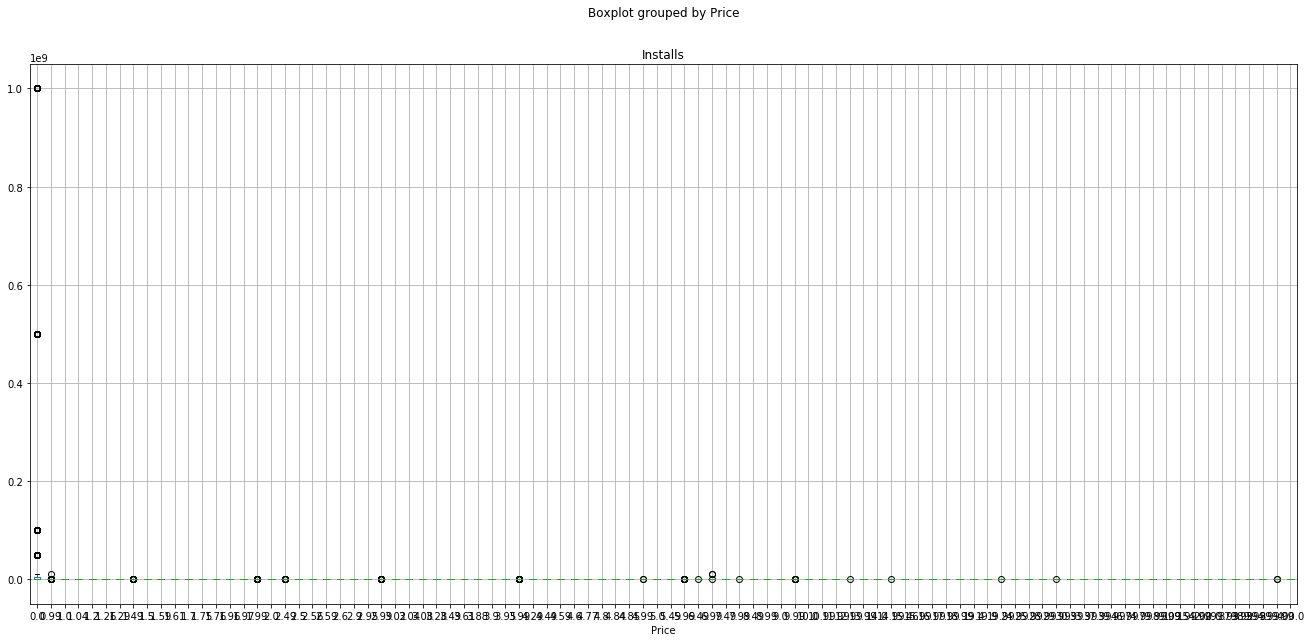

In [122]:
store_data_copy.boxplot(column='Installs', by='Price', figsize=(22,10))

Done: (Price & Count), (Type & Count), (Category & Rating) 


Yet to be done: 1- Visualization: Installs & Price, Installs & Category (Installs axis can be entered as an array of the unique Installs values)


   2- Cleaning: Split Genres


Attempted: Size & Installs